# Case of study for 'Data modelling'
## TOC



**Goal**\
The goal of this study is to predict the atomization energy of molecules made up of C, H, N, O, P, and S (CHNOPS). \
Atomization energy is the energy required to break all the chemical bonds in a molecule and convert each atom to a ground state.

**Dataset**\
The dataset (available at following [link](https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule?rvi=1)) is composed of 16242 molecules (taken from PubChem Substance and Compound database) and they satisfy the following criteria: 
+ Each molecule has to be composed of a subset of the elements from the set C,H, N, O, P and S (CHNOPS);
+ Each molecule must have at least 2 and at most 50 atoms;
+ The maximum distance between two atoms in a molecule must not exceed 25 a0 (a0 = 0.529 Å, i.e., Bohr radius);
+ There must be an even number of electrons in the molecule.

The electronic structure calculation was performed using the plane-waves pseudopotential implementation of DFT in the PWSCF code of the Quantum ESPRESSO package. 

The features used to predict the atomization energies are the elements of the Coulomb matrix (C$_{IJ}$), that describes the ionic repulsion between pair atoms:
![alt text](./coulomb_matrix.png)

where Z$_I$ are atomic numbers, R$_I$ are atomic coordinates, and indices I, J run over the atoms in a given molecule.

The dataset is composed of 1275 features (listed in columns) that are the elements of upper triangular part of the Coulomb matrix. Molecules with less than 50 atoms have their Coulomb matrices appended by columns and rows of 0
to complete them to have dimensions of 50 × 50.


## TOC:
* [First steps](#first)
    * [Exploratory data analysis](#exploratory)
    * [Create a new dataframe of eigevalues](#eigevalues)
    * [PCA](#pca)
* [Training and testing the data](#training)
    * [Test1: Coulomb matrix and eigenvalues features](#coul_eig)
    * [Test2: PCA-reducted features](#pca_red)
    * [Neural network on molecules dataset](#nn_mol)
    * [Neural network on eigenvalues dataset](#nn_eig)
* [Conclusions](#conclusions)

## First step  <a name="first"></a>

In [1]:
'''Importing Python libraries'''
import numpy as np
import pandas as pd
from scipy.linalg import issymmetric
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sklearn.decomposition as PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
'''Load data'''
df_mol = pd.read_csv('path/roboBohr.csv')

### Exploratory data analysis <a name="exploratory"></a>

In [3]:
print(df_mol.head())
print(df_mol.dtypes)
print('Total null values: ', sum(pd.isnull(df_mol).any())) #Checking Null values / missing values

   Unnamed: 0          0          1          2          3          4  \
0           0  73.516695  17.817765  12.469551  12.458130  12.454607   
1           1  73.516695  20.649126  18.527789  17.891535  17.887995   
2           2  73.516695  17.830377  12.512263  12.404775  12.394493   
3           3  73.516695  17.875810  17.871259  17.862402  17.850920   
4           4  73.516695  17.883818  17.868256  17.864221  17.818540   

           5          6          7          8  ...  1267  1268  1269  1270  \
0  12.447345  12.433065  12.426926  12.387474  ...   0.0   0.0   0.5   0.0   
1  17.871731  17.852586  17.729842  15.864270  ...   0.0   0.0   0.0   0.0   
2  12.391564  12.324461  12.238106  10.423249  ...   0.0   0.0   0.0   0.0   
3  17.850440  12.558105  12.557645  12.517583  ...   0.0   0.0   0.0   0.0   
4  12.508657  12.490519  12.450098  10.597068  ...   0.0   0.0   0.0   0.0   

   1271  1272  1273  1274  pubchem_id        Eat  
0   0.0   0.0   0.0   0.0       25004 -19.01376

In [4]:
df_mol = df_mol.drop('Unnamed: 0', axis=1) # delete col:Unnamed
print(df_mol.columns)
print(df_mol.shape)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1267', '1268', '1269', '1270', '1271', '1272', '1273', '1274',
       'pubchem_id', 'Eat'],
      dtype='object', length=1277)
(16242, 1277)


In [5]:
df_mol['Eat'].describe()

count    16242.000000
mean       -11.178969
std          3.659133
min        -23.245373
25%        -13.475805
50%        -10.835211
75%         -8.623903
max         -0.789513
Name: Eat, dtype: float64

Text(0.5, 0, 'Atomization Energies (Ry)')

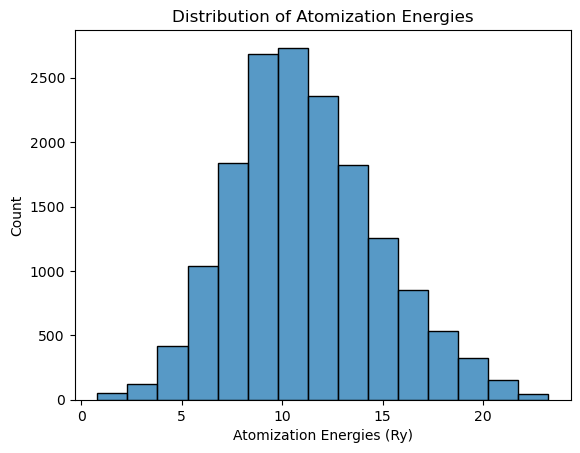

In [14]:
# Distribution of Atomization Energies 
sns.histplot(abs(df_mol['Eat']), bins=15)
plt.title('Distribution of Atomization Energies')
plt.xlabel('Atomization Energies (Ry)')

### Create a new dataframe of eigevalues <a name="eigevalues"></a>
To reduce the size of the dataframe we don't consider the Coulomb matrix (that is a vector of 1275 elements), but we calculate the eigenvalues whose dimention is 50.\
The steps to create the eigenvalues dataframe are:
- Iniziatize a new empty dataframe
- For each molecule (rows)
    - create a square matrix (see create_symmetric_matrix function)
    - calculate the eigenvalues
    - fill the dataset
- Rename columns and transpose
- Finally save the data

In [6]:
def create_symmetric_matrix(values, size):
    upper = np.zeros((size, size))
    lower = np.zeros((size, size))
    symmetric = np.zeros((size, size))
       
    upper[np.triu_indices(size)] = values
    lower = lower +np.transpose(upper)
    
    for i in range(size):
        lower[i][i]=0
    
    symmetric = upper + lower
    return(symmetric)



In [7]:
# test for a simple matrix
test = create_symmetric_matrix([1, 2, 3, 4, 5, 6], 3 )
issymmetric(test)

True

In [9]:
'''Load data'''
df_eigval = pd.read_csv('path/dataframe_eigvalues.csv')

In [10]:
df_eigval = pd.concat([df_eigval, df_mol['Eat']], axis=1)
df_eigval

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Eat
0,-22.446062,-0.983384,-0.000012,0.041038,0.140300,2.718015e-01,2.842093e-01,3.217404e-01,3.510147e-01,3.586871e-01,...,35.978626,36.096316,36.186206,36.258335,36.298734,36.376473,36.434393,36.598931,138.208854,-19.013763
1,-35.508667,-0.028013,-0.003718,-0.000325,-0.000137,-3.587773e-05,-6.438320e-07,-3.044687e-15,-2.254420e-15,-1.776240e-15,...,36.857910,36.858098,36.858106,50.109178,58.724607,67.795389,71.745832,72.624159,147.986344,-10.161019
2,-14.133155,-0.262767,-0.000502,-0.000121,-0.000075,-1.749682e-06,-2.069966e-15,-1.672329e-15,-1.416694e-15,-1.366990e-15,...,0.500000,23.508087,34.921270,35.612367,35.962498,36.627395,36.706116,36.858590,106.190808,-9.376619
3,-24.876607,-0.525016,-0.001143,-0.000461,-0.000020,-9.908569e-06,-1.496698e-06,-1.174199e-06,-3.511855e-07,-1.230171e-07,...,36.188381,36.295998,36.484495,36.633780,36.727370,36.751982,60.747613,69.698680,139.551247,-13.776438
4,-16.211294,-0.092665,-0.002430,-0.000183,-0.000015,-1.765585e-15,-1.634779e-15,-1.161774e-15,-1.060343e-15,-8.105245e-16,...,0.500000,21.726671,35.632790,36.431004,36.704297,36.858105,36.858144,65.508786,115.259772,-8.537140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,-24.266535,-0.096435,-0.000309,-0.000267,-0.000074,-3.545977e-15,-3.419323e-15,-2.852097e-15,-1.980214e-15,-1.645373e-15,...,36.628201,36.849693,36.857876,36.858102,36.858974,58.538377,70.460060,72.367048,131.580148,-8.876123
16238,-29.971455,-0.044388,-0.000810,-0.000672,-0.000146,-1.937185e-05,-1.413394e-05,-5.115243e-06,-6.942534e-07,-4.212445e-07,...,36.277310,36.481035,36.682441,36.761313,36.857722,36.867539,36.873501,60.489172,142.380008,-13.105268
16239,-37.430045,-0.006134,-0.000241,-0.000178,-0.000050,-1.452727e-05,-5.582442e-06,-3.136513e-06,-7.512468e-07,-4.124164e-07,...,36.366944,36.551078,36.665423,36.719506,36.757350,36.784303,46.186863,49.428536,152.214380,-16.801464
16240,-32.278286,-0.050821,-0.012735,-0.000417,-0.000067,-2.842491e-05,-1.466569e-05,-1.730542e-06,-2.006682e-07,-7.132609e-08,...,36.056584,36.223336,36.471651,36.683321,36.730299,36.764696,36.858038,43.550976,121.224000,-13.335088


### Principal Component Analysis <a name="pca"></a>
PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data.Standardizing the data before applying PCA is necessary. A disadvantage of the method is that it may reduce the accuracy of the prediction.

Dimensions of data after PCA:  (16242, 2)
how much variance is explained by each principal component:  [0.62156382 0.1748646 ]


<function matplotlib.pyplot.show(close=None, block=None)>

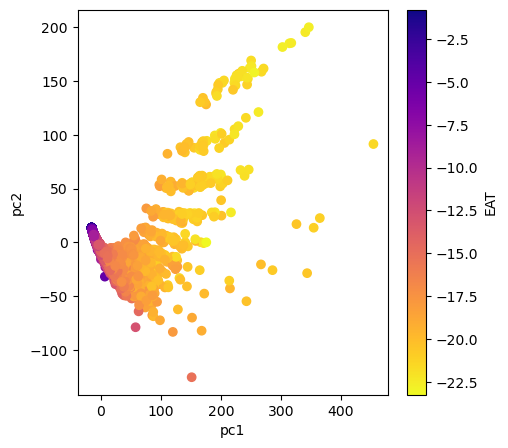

In [13]:
# construct a dataframe of features from Coulomb matrix

# Scale data before applying PCA
scaler=StandardScaler()
x = scaler.fit_transform(df_mol.drop(['pubchem_id','Eat'] , axis='columns'))

# Set the number of principal components
principal=PCA(n_components=2)
x_pca=principal.fit_transform(x)

# Check the dimensions of data after PCA
print('Dimensions of data after PCA: ', x_pca.shape)


# check how much variance is explained by each principal component
print('how much variance is explained by each principal component: ' ,principal.explained_variance_ratio_)

plt.figure(figsize=(5,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df_mol['Eat'],cmap='plasma_r')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.colorbar(label="EAT", orientation="vertical") 
plt.show

Dimensions of data after PCA:  (16242, 2)
how much variance is explained by each principal component:  [0.3451118  0.13167426]


<function matplotlib.pyplot.show(close=None, block=None)>

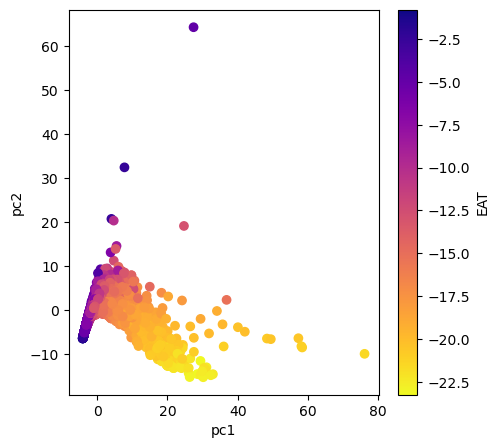

In [14]:
# construct a dataframe of features from eigenvalues matrix

# Scale data before applying PCA
scaler=StandardScaler()
x_lambda = scaler.fit_transform(df_eigval.drop(['Eat'] , axis='columns'))

# Set the number of principal components
principal=PCA(n_components=2)
x_pca_lambda=principal.fit_transform(x_lambda)

# Check the dimensions of data after PCA
print('Dimensions of data after PCA: ', x_pca_lambda.shape)


# check how much variance is explained by each principal component
print('how much variance is explained by each principal component: ' ,principal.explained_variance_ratio_)

plt.figure(figsize=(5,5))
plt.scatter(x_pca_lambda[:,0],x_pca_lambda[:,1],c=df_mol['Eat'],cmap='plasma_r')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.colorbar(label="EAT", orientation="vertical") 
plt.show


## Training and testing data <a name="training"></a>
In this section, I tested different methods to evaluate which performs best. The datasets are randomly divided into a training (70%) and test set (30%).

In [16]:
# add libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

In [17]:
# definisci una funzione per valutare l'accuratezza dei modelli
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAE = mean_absolute_error(y_test, y_pred)
    return MSE , RMSE, MAE

### Test1: Coulomb matrix and eigenvalues features 
<a name="coul_eig"></a>

In [19]:
## 1 split train-test

# Coulomb matrix


df_results1 = pd.DataFrame()
df_results1 = pd.DataFrame(columns=['dataset','model_name','MSE','RMSE','MAE'],dtype=object)


#model
model_list = [LinearRegression(), linear_model.Lasso(alpha=0.1),\
              RandomForestRegressor()]

### split 
X = df_mol.drop(['pubchem_id','Eat'], axis='columns' )
y = df_mol['Eat']     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



## standardizzare i valori  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
xn_train = scaler.transform(X_train)  
# apply same transformation to test data
xn_test = scaler.transform(X_test)  




for model in model_list:
    mse, rmse, mae= get_score(model, xn_train, xn_test, y_train, y_test)
    
    model_name = model
    if isinstance(model, RandomForestRegressor):
        model_name = 'RandomForest'
    print(model_name)
    df_results1 = pd.concat([df_results1, pd.DataFrame({'dataset': 'coul_matrix','model_name': model_name,\
                                                        'MSE': mse, 'RMSE': rmse, 'MAE' : mae}, index=[0])],  ignore_index=True)

LinearRegression()
Lasso(alpha=0.1)
RandomForest


In [20]:
# eigenvalues matrix


#model
model_list = [LinearRegression(), linear_model.Lasso(alpha=0.1),\
              RandomForestRegressor()]


X = df_eigval.drop(['Eat'], axis='columns' )
y = df_eigval['Eat']     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


## standardizzare i valori  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
xn_train = scaler.transform(X_train)  
# apply same transformation to test data
xn_test = scaler.transform(X_test)  




for model in model_list:
    mse, rmse, mae= get_score(model, xn_train, xn_test, y_train, y_test)
    model_name = model
    if isinstance(model, RandomForestRegressor):
        model_name = 'RandomForest'
    print(model_name)
    df_results1 = pd.concat([df_results1, pd.DataFrame({'dataset': 'eigeinvalues','model_name': model_name,\
                                                        'MSE': mse, 'RMSE': rmse, 'MAE' : mae}, index=[0])],  ignore_index=True)

LinearRegression()
Lasso(alpha=0.1)
RandomForest


In [21]:
df_results1

,dataset,model_name,MSE,RMSE,MAE
0,coul_matrix,LinearRegression(),2337.976903,48.352631,4.674296
1,coul_matrix,Lasso(alpha=0.1),1.107432,1.052346,0.712593
2,coul_matrix,RandomForest,0.021659,0.147169,0.087788
3,eigeinvalues,LinearRegression(),2.034737,1.426442,0.860706
4,eigeinvalues,Lasso(alpha=0.1),2.050872,1.432086,0.958301
5,eigeinvalues,RandomForest,0.028886,0.169959,0.105330


### Test2: PCA-reducted features <a name="pca_red"></a> 

In [ ]:
# PCA on coulomb matrix

# split training - test (70-30)
df_results2 = pd.DataFrame()
df_results2 = pd.DataFrame(columns=['dataset','model_name','MSE','RMSE','MAE'],dtype=object)


#model
model_list = [LinearRegression(), linear_model.Lasso(alpha=0.1),\
              RandomForestRegressor()]

### split 
X = df_mol.drop(['pubchem_id','Eat'], axis='columns' )
y = df_mol['Eat']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
###########################################
scaler = StandardScaler()
# Fit on the train set only
scaler.fit(X_train)
# Apply to both the train set and the test set. 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Apply PCA
pca = PCA()
# Fit on the train set only
pca.fit(X_train)
# Apply transform to both the train set and the test set. 
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)




for model in model_list:
    mse, rmse, mae= get_score(model, X_pca_train, X_pca_test, y_train, y_test)
    
    model_name = model
    if isinstance(model, RandomForestRegressor):
        model_name = 'RandomForest'
    #print(model_name)
    df_results2= pd.concat([df_results2, pd.DataFrame({'dataset': 'PCA','model_name': model_name,\
                                                        'MSE': mse, 'RMSE': rmse, 'MAE' : mae}, index=[0])],  ignore_index=True)

In [ ]:
# PCA on eig matrix

# split training - test (70-30)


#model
model_list = [LinearRegression(), linear_model.Lasso(alpha=0.1),\
              RandomForestRegressor()]

### split 
X = df_eigval.drop(['Eat'], axis='columns' )
y = df_eigval['Eat']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
###########################################
scaler = StandardScaler()
# Fit on the train set only
scaler.fit(X_train)
# Apply to both the train set and the test set. 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Apply PCA
pca = PCA()
# Fit on the train set only
pca.fit(X_train)
# Apply transform to both the train set and the test set. 
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)



for model in model_list:
    mse, rmse, mae= get_score(model, X_pca_train, X_pca_test, y_train, y_test)
    
    model_name = model
    if isinstance(model, RandomForestRegressor):
        model_name = 'RandomForest'
    #print(model_name)
    df_results2 = pd.concat([df_results2, pd.DataFrame({'dataset': 'PCA_eig','model_name': model_name,\
                                                        'MSE': mse, 'RMSE': rmse, 'MAE' : mae}, index=[0])],  ignore_index=True)

In [68]:
df_results2

,dataset,model_name,MSE,RMSE,MAE
0,PCA,LinearRegression(),4.356307e+19,6.600232e+09,3.446079e+08
1,PCA,Lasso(alpha=0.1),8.650822e-01,9.300980e-01,6.564329e-01
2,PCA,RandomForest,5.823884e-02,2.413272e-01,1.618123e-01
3,PCA_eig,LinearRegression(),5.800285e+00,2.408378e+00,8.760872e-01
4,PCA_eig,Lasso(alpha=0.1),2.433190e+00,1.559869e+00,1.002969e+00
5,PCA_eig,RandomForest,1.899744e-01,4.358606e-01,2.085691e-01


### Neural network on molecules dataset <a name="nn_mol"></a> 

In [65]:
xn = df_mol.drop(['pubchem_id','Eat'], axis='columns' )
yn = df_mol['Eat']

xn_train, xn_test, yn_train, yn_test = train_test_split(xn, yn, test_size=0.3)
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(xn_train)  
xn_train = scaler.transform(xn_train)  
# apply same transformation to test data
xn_test = scaler.transform(xn_test)  

# Create an MLPRegressor object
clf = MLPRegressor(hidden_layer_sizes=(3), max_iter=1000)
# Train the model
clf.fit(xn_train, yn_train)
# Predict the output for a new input
print(clf.predict(xn_test))

y_pred = clf.predict(xn_test)
MSE = mean_squared_error(yn_test, y_pred)
RMSE = mean_squared_error(yn_test, y_pred, squared=False)
MAE = mean_absolute_error(yn_test, y_pred)
print('MSE:', MSE, '\n')
print('RMSE:', RMSE, '\n')
print('MAE:', MAE, '\n')

[-14.01354389 -12.76657009  -9.06921971 ...  -8.36268768 -14.36582246
 -12.73331757]
MSE: 0.36796899473202116 

RMSE: 0.606604479650473 

MAE: 0.386893960806978 



### Neural network on eigenvalues dataset  <a name="nn_eig"></a> 

In [59]:
xn = df_eigval.drop(['Eat'], axis='columns' )
yn = df_eigval['Eat'] 

xn_train, xn_test, yn_train, yn_test = train_test_split(xn, yn, test_size=0.3)
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(xn_train)  
xn_train = scaler.transform(xn_train)  
# apply same transformation to test data
xn_test = scaler.transform(xn_test)  

# Create an MLPRegressor object
clf = MLPRegressor(hidden_layer_sizes=3, max_iter=1000)
# Train the model
clf.fit(xn_train, yn_train)
# Predict the output for a new input
print(clf.predict(xn_test))

y_pred = clf.predict(xn_test)
MSE = mean_squared_error(yn_test, y_pred)
RMSE = mean_squared_error(yn_test, y_pred, squared=False)
MAE = mean_absolute_error(yn_test, y_pred)
print('MSE:', MSE, '\n')
print('RMSE:', RMSE, '\n')
print('MAE:', MAE, '\n')

[-14.47787448 -15.18295571 -14.28011607 ...  -9.81912708 -15.51674217
 -12.02515959]
MSE: 0.7568862242600809 

RMSE: 0.869992082872069 

MAE: 0.5857286921856312 



## Conclusions  <a name="conclusions"></a> 

In [57]:
from rich.table import Table
from rich.console import Console

In [66]:
table = Table(title="Paper results")

table.add_column("Features", style="cyan", no_wrap=True)
table.add_column("Method", style="magenta")
table.add_column("Test error (eV)", style="green")

table.add_row("Eigenvalues", "Boosted tree/ 5-fold", "1.67")
table.add_row("Eigenvalues", "Neural netw. / 5-fold", "2.40")
table.add_row("Coul. matrix", "Boosted tree/ 5-fold", "1.45")
table.add_row("Coul. matrix", "Neural netw. / 5-fold", "2.34")


table2 = Table(title="My results")

table2.add_column("Features", style="cyan", no_wrap=True)
table2.add_column("Method", style="magenta")
table2.add_column("Test error (eV)", style="green")

table2.add_row("Eigenvalues", "Random forest", "2.31")
table2.add_row("Eigenvalues", "Neural netw.", "11.8")
table2.add_row("Coul. matrix", "Random forest", "2.04")
table2.add_row("Coul. matrix", "Neural netw.", "8.16")
console = Console()
console.print(table)
console.print(table2)

                      Paper results                       
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Features     ┃ Method                ┃ Test error (eV) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Eigenvalues  │ Boosted tree/ 5-fold  │ 1.67            │
│ Eigenvalues  │ Neural netw. / 5-fold │ 2.40            │
│ Coul. matrix │ Boosted tree/ 5-fold  │ 1.45            │
│ Coul. matrix │ Neural netw. / 5-fold │ 2.34            │
└──────────────┴───────────────────────┴─────────────────┘

                    My results                    
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Features     ┃ Method        ┃ Test error (eV) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Eigenvalues  │ Random forest │ 2.31            │
│ Eigenvalues  │ Neural netw.  │ 11.8            │
│ Coul. matrix │ Random forest │ 2.04            │
│ Coul. matrix │ Neural netw.  │ 8.16            │
└──────────────┴───────────────┴─────────────────┘